In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

2022-12-14 10:24:05,612 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [4]:
# Load dataset
exp_name = 'tau_sweep/aquaplanet/k=1'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

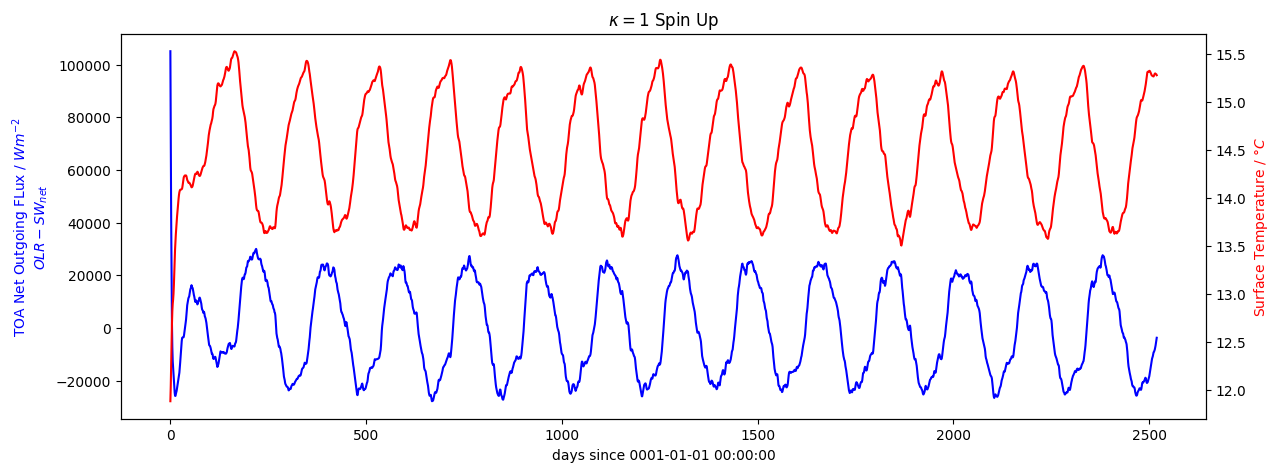

In [5]:
# Plot spin up time
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau_sw), ds.t_surf, ax)
plt.title(f'$\kappa = {tau_lw}$ Spin Up');

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

We do this for the Northern Hemisphere Summer and conditioned on days for which the surface temperature was more than the 99th percentile at that latitude, over all longitudes and times.

This shows that for the high percentile days, the atmosphere is convectively neutral through most of the troposphere for almost all latitudes.

In [69]:
# Take time and zonal mean
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
quantile = 99
pressure_ft = 700

# Perpetual Equinox near surface MSE and Free troposphere saturated MSE
# ds_use = ds.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon', 'time'])
# mse_surface = moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1])
#
# ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')
# mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
# sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
# mse_ft_sat = moist_static_energy(ds_ft.temp, sphum_sat, ds_ft.height)

# Northern hemisphere summer near surface MSE and Free troposphere saturated MSE
ds_summer = ds.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon'])
ds_summer = isca_tools.utils.annual_time_slice(ds_summer, [6, 7, 8]).mean(dim=['time'])    # NH summer is JJA
mse_surface_summer = moist_static_energy(ds_summer.temp[-1], ds_summer.sphum[-1], ds_summer.height[-1])
ds_ft_summer = ds_summer.sel(pfull=pressure_ft, method='nearest')
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft_summer.temp), ds_ft_summer.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat_summer = moist_static_energy(ds_ft_summer.temp, sphum_sat, ds_ft_summer.height)

# MSE conditioned on > 99 quantile temperature days at the given latitude over all longitude and time
ds_quantile = ds.sel(time=slice(use_time_start, np.inf)).stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
# Compute minimum temperature allowed at each latitude
quantile_thresh = ds_quantile.t_surf.quantile(quantile/100, dim='lon_time', keep_attrs=True)
# marked with NaN where below temperature threshold over given latitude, hence skipna
ds_quantile = ds_quantile.where(ds_quantile.t_surf>=quantile_thresh).mean(dim='lon_time', skipna=True)

mse_surface_quantile = moist_static_energy(ds_quantile.temp[-1], ds_quantile.sphum[-1], ds_quantile.height[-1])
ds_ft_quantile = ds_quantile.sel(pfull=pressure_ft, method='nearest')
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft_quantile.temp), ds_ft_quantile.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat_quantile = moist_static_energy(ds_ft_quantile.temp, sphum_sat, ds_ft_quantile.height)



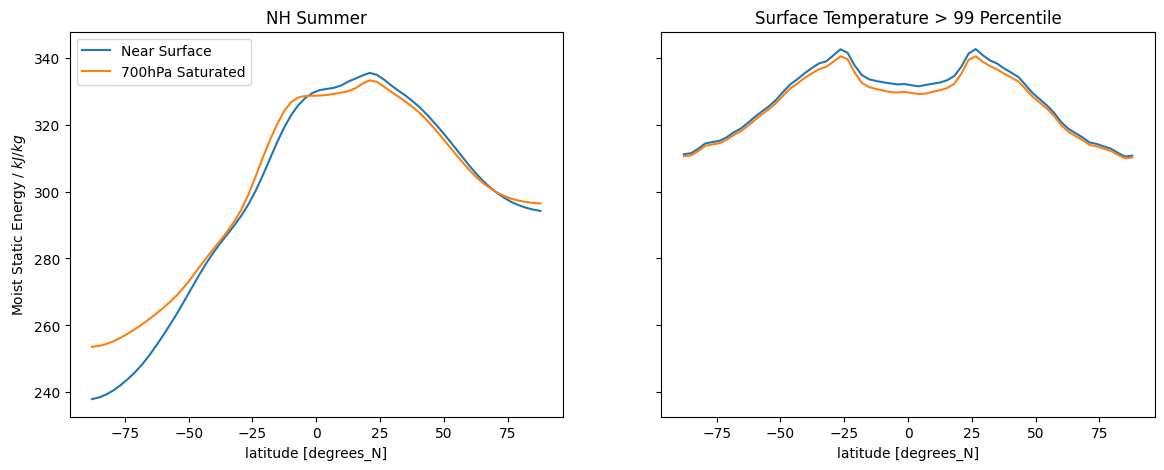

In [71]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
mse_surface_summer.plot.line(ax=axs[0], add_legend=False, label="Near Surface")
mse_ft_sat_summer.plot.line(ax=axs[0], add_legend=False, label=f"{pressure_ft}hPa Saturated")
axs[0].legend()
axs[0].set_ylabel('Moist Static Energy / $kJ/kg$')

mse_surface_quantile.plot.line(ax=axs[1], add_legend=False, label="Near Surface")
mse_ft_sat_quantile.plot.line(ax=axs[1], add_legend=False, label=f"{pressure_ft}hPa Saturated")
axs[0].set_title('NH Summer')
axs[1].set_title(f'Surface Temperature > {quantile} Percentile');

In [72]:
# Consider each latitude and pressure value and compute difference between surface MSE and saturation MSE
# NH Summer
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_summer.temp), ds_summer.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_all_sat = moist_static_energy(ds_summer.temp, sphum_sat, ds_summer.height)
mse_all_sat.name = 'saturation moist static energy'

mse_diff_summer = (mse_surface_summer-mse_all_sat)/mse_surface_summer
mse_diff_summer.name = '(Surface MSE - Saturation MSE)/Surface MSE'

# High Quantile
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_quantile.temp), ds_quantile.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_all_sat = moist_static_energy(ds_quantile.temp, sphum_sat, ds_quantile.height)
mse_all_sat.name = 'saturation moist static energy'

mse_diff_quantile = (mse_surface_quantile-mse_all_sat)/mse_surface_quantile
mse_diff_quantile.name = '(Surface MSE - Saturation MSE)/Surface MSE';

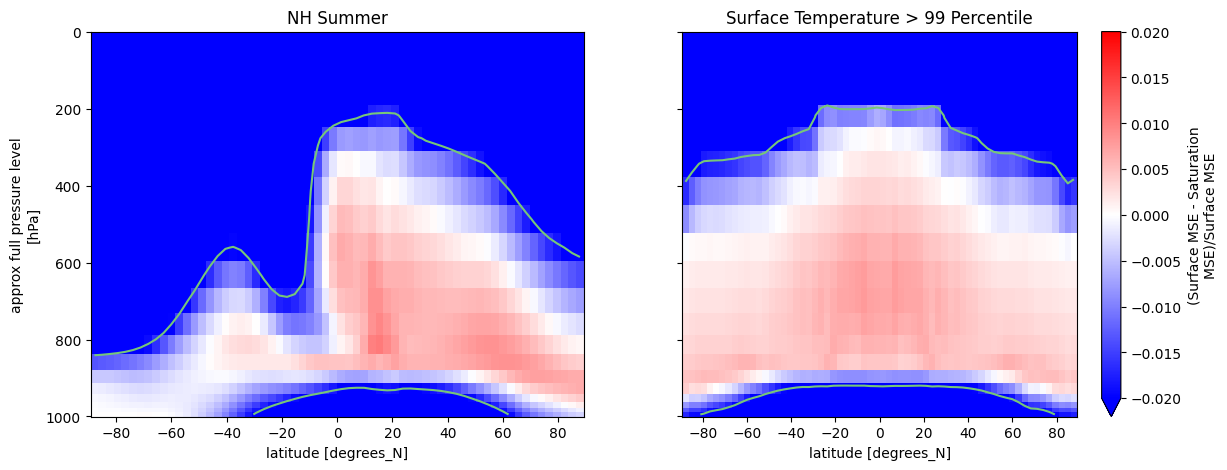

In [73]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
mse_diff_summer.plot.pcolormesh(ax=axs[0], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat', add_colorbar=False)
mse_diff_quantile.plot.pcolormesh(ax=axs[1], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat')
# Show contour where the dofference falls below 2%
axs[0].contour(mse_diff_summer.lat.to_numpy(), mse_diff_summer.pfull.to_numpy(), mse_diff_summer.to_numpy().transpose(), [-0.02, 0.02],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].contour(mse_diff_quantile.lat.to_numpy(), mse_diff_quantile.pfull.to_numpy(), mse_diff_quantile.to_numpy().transpose(), [-0.02, 0.02],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].set_ylabel('')
axs[0].set_title('NH Summer')
axs[1].set_title(f'Surface Temperature > {quantile} Percentile');

In [86]:
# Plot temperature profiles for tropics and extratropics.
# Compare them to convectively neutral profiles
lat_max_tropics = 20
lat_min_extrop = 30
lat_max_extrop = 60

# NH Summer
ds_tropics_summer = ds_summer.where(np.abs(ds_summer.lat)<lat_max_tropics, drop=True)
ds_tropics_summer = area_weight_mean_lat(ds_tropics_summer)
tropics_temp_profile_summer = convection_neutral_profile(float(ds_tropics_summer.temp[-1]), float(ds_tropics_summer.sphum.pfull[-1])*100,
                                                         float(ds_tropics_summer.sphum[-1]), ds_tropics_summer.temp.pfull.to_numpy()*100)

ds_extrop_summer = ds_summer.where(np.logical_and(ds_summer.lat<lat_max_extrop, ds_summer.lat>=lat_min_extrop), drop=True)
ds_extrop_summer = area_weight_mean_lat(ds_extrop_summer)
extrop_temp_profile_summer = convection_neutral_profile(float(ds_extrop_summer.temp[-1]), float(ds_extrop_summer.sphum.pfull[-1])*100,
                                                        float(ds_extrop_summer.sphum[-1]), ds_extrop_summer.temp.pfull.to_numpy()*100)

# High Temp days
ds_tropics_quantile = ds_quantile.where(np.abs(ds_quantile.lat)<lat_max_tropics, drop=True)
ds_tropics_quantile = area_weight_mean_lat(ds_tropics_quantile)
tropics_temp_profile_quantile = convection_neutral_profile(float(ds_tropics_quantile.temp[-1]),
                                                           float(ds_tropics_quantile.sphum.pfull[-1])*100,
                                                           float(ds_tropics_quantile.sphum[-1]),
                                                           ds_tropics_quantile.temp.pfull.to_numpy()*100)

ds_extrop_quantile = ds_quantile.where(np.logical_and(ds_quantile.lat<lat_max_extrop,
                                                      ds_quantile.lat>=lat_min_extrop), drop=True)
ds_extrop_quantile = area_weight_mean_lat(ds_extrop_quantile)
extrop_temp_profile_quantile = convection_neutral_profile(float(ds_extrop_quantile.temp[-1]),
                                                          float(ds_extrop_quantile.sphum.pfull[-1])*100,
                                                          float(ds_extrop_quantile.sphum[-1]),
                                                          ds_extrop_quantile.temp.pfull.to_numpy()*100)

Variables Averaged: ['pk', 'height', 'temp', 'ps', 'sphum', 'ucomp', 'vcomp', 'omega', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 't_surf', 'precipitation', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']
Variables Averaged: ['pk', 'height', 'temp', 'ps', 'sphum', 'ucomp', 'vcomp', 'omega', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 't_surf', 'precipitation', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']
Variables Averaged: ['pk', 'height', 'temp', 'ps', 'sphum', 'ucomp', 'vcomp', 'omega', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 't_surf', 'precipitation', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']
Variables Averaged: ['pk', 'height', 'temp', 'ps', 'sphum', 'ucomp', 'vcomp', 'omega', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 't_surf', 'precipitation', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']


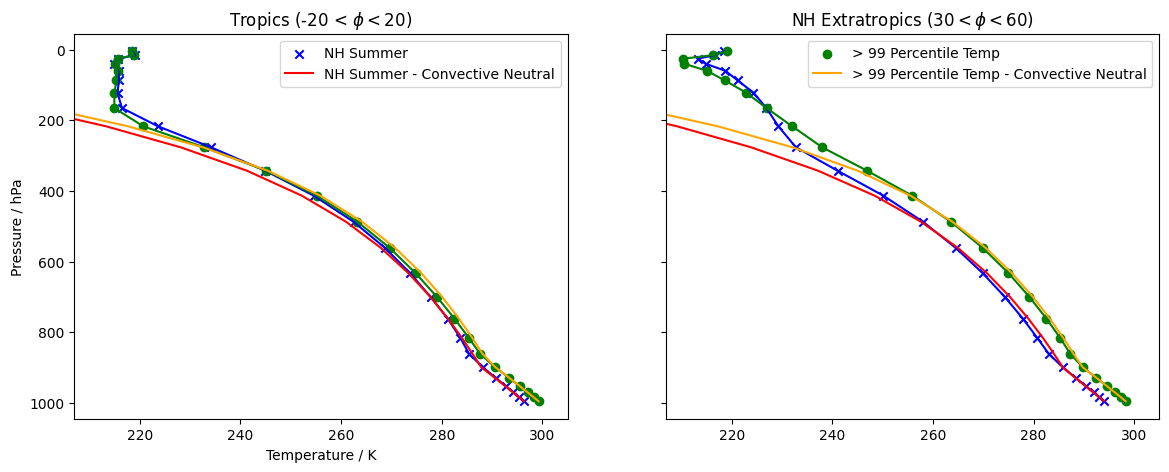

In [93]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
axs[0].plot(ds_tropics_summer.temp.to_numpy(), ds_tropics_summer.temp.pfull.to_numpy(), color='b')
axs[0].scatter(ds_tropics_summer.temp.to_numpy(), ds_tropics_summer.temp.pfull.to_numpy(), label='NH Summer', color='b', marker='x')
axs[0].plot(tropics_temp_profile_summer, ds_tropics_summer.temp.pfull.to_numpy(), label='NH Summer - Convective Neutral', color='r')

axs[0].plot(ds_tropics_quantile.temp.to_numpy(), ds_tropics_quantile.temp.pfull.to_numpy(), color='g')
axs[0].scatter(ds_tropics_quantile.temp.to_numpy(), ds_tropics_quantile.temp.pfull.to_numpy(), color='g', marker='o')
axs[0].plot(tropics_temp_profile_quantile, ds_tropics_quantile.temp.pfull.to_numpy(), color='orange')

axs[1].plot(ds_extrop_summer.temp.to_numpy(), ds_extrop_summer.temp.pfull.to_numpy(), color='b')
axs[1].scatter(ds_extrop_summer.temp, ds_extrop_summer.temp.pfull.to_numpy(), color='b', marker='x')
axs[1].plot(extrop_temp_profile_summer, ds_extrop_summer.temp.pfull.to_numpy(), color='r')

axs[1].plot(ds_extrop_quantile.temp.to_numpy(), ds_extrop_quantile.temp.pfull.to_numpy(), color='g')
axs[1].scatter(ds_extrop_quantile.temp, ds_extrop_quantile.temp.pfull.to_numpy(),
               label=f'> {quantile} Percentile Temp', color='g', marker='o')
axs[1].plot(extrop_temp_profile_quantile, ds_extrop_quantile.temp.pfull.to_numpy(),
            label=f'> {quantile} Percentile Temp - Convective Neutral', color='orange')

axs[0].invert_yaxis()
axs[0].set_xlim([207, 305])
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('Temperature / K')
axs[0].set_ylabel('Pressure / hPa')
axs[0].set_title(f'Tropics (-{lat_max_tropics} < $\phi < {lat_max_tropics}$)')
axs[1].set_title(f'NH Extratropics (${lat_min_extrop} < \phi < {lat_max_extrop}$)');